In [2]:
import os
os.chdir("../")
from data_management.DataManager import CALFData, collateGCN
import numpy as np
import torch 
from Model import ContextAwareModel
from helpers.loss import ContextAwareLoss, SpottingLoss
from modules.train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from modules.GameAnalysis import GamaAnalysis
import seaborn as sns
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params
import torch.nn as nn

In [8]:
@dataclass
class Args:
    receptive_field = 12
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 60
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 1
    K_parameters = get_K_params(chunk_size)
    focused_annotation = "Duel"
    generate_augmented_data = True
    sgementation_path = "models/gridsearch5.pth.tar"
    freeze_model = True
    generate_artificial_targets = False

In [12]:
args = Args
collate_fn = collateGCN
list_anns = list(event_enc.keys())[6:]

for ann in list_anns:
    print(f"\n {ann}")
    args.focused_annotation = ann
    
    # Read data for specific annotation
    train_dataset = CALFData(split="train", args=args)
    validation_dataset = CALFData(split="validate", args=args)

    train_loader = torch.utils.data.DataLoader(train_dataset,
                batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

    validate_loader = torch.utils.data.DataLoader(validation_dataset,
                batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

    # Load pre-trained model and adjust it
    model = torch.load(args.sgementation_path)
    model.num_classes = 1
    model.conv_seg = nn.Conv2d(in_channels=152, out_channels=model.dim_capsule, kernel_size=(model.kernel_seg_size,1))
    
    criterion = ContextAwareLoss(K=train_dataset.K_parameters)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                                betas=(0.9, 0.999), eps=1e-07, 
                                weight_decay=0, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

    losses = trainer(train_loader, validate_loader,
                        model, optimizer, scheduler, 
                        criterion,
                        model_name=args.model_name,
                        max_epochs=args.max_epochs, 
                        save_dir=f"models/finetuned_{ann}.pth.tar")

    with open(f'results/finetuned_{ann}.pkl', 'wb') as file:
        pickle.dump(losses, file)
    
    del train_dataset,validation_dataset,train_loader, validate_loader,model


 Clearance


Get labels & features: 100%|██████████| 8/8 [02:11<00:00, 16.42s/it]
Train 1: Time 6.513s (it:5.236s) Data:1.338s (it:1.103s) Loss 3.3091e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:11<00:00,  6.51s/it]
Evaluate 1: Time 3.399s (it:2.854s) Data:1.006s (it:0.848s) Loss 5.7750e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:13<00:00,  3.40s/it]
Train 2: Time 6.538s (it:5.493s) Data:1.312s (it:1.137s) Loss 3.1462e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:12<00:00,  6.54s/it]
Evaluate 2: Time 3.657s (it:4.106s) Data:1.030s (it:0.831s) Loss 4.6787e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:28<00:00,  3.66s/it]
Train 3: Time 6.952s (it:6.902s) Data:1.437s (it:1.211s) Loss 3.0325e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:36<00:00,  6.95s/it]
Evaluate 3: Time 3.811s (it:2.596s) Data:1.074s (it:0.866s) Loss 3.8304e+00 : 100%|███████████████████████████████████████████


 Goal Keeper


Get labels & features: 100%|██████████| 8/8 [02:12<00:00, 16.62s/it]
Train 1: Time 6.219s (it:5.224s) Data:1.248s (it:1.078s) Loss 3.1403e+00 : 100%|████████████████████████████████████████████████| 57/57 [05:54<00:00,  6.22s/it]
Evaluate 1: Time 3.391s (it:3.747s) Data:0.993s (it:0.760s) Loss 7.1965e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:13<00:00,  3.39s/it]
Train 2: Time 6.319s (it:4.982s) Data:1.276s (it:1.075s) Loss 2.8190e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:00<00:00,  6.32s/it]
Evaluate 2: Time 3.408s (it:2.786s) Data:1.008s (it:0.833s) Loss 5.1517e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:14<00:00,  3.41s/it]
Train 3: Time 6.318s (it:5.256s) Data:1.282s (it:1.171s) Loss 2.7424e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:00<00:00,  6.32s/it]
Evaluate 3: Time 3.442s (it:2.812s) Data:1.011s (it:0.809s) Loss 4.2578e+00 : 100%|███████████████████████████████████████████


 Pass


Get labels & features: 100%|██████████| 8/8 [02:16<00:00, 17.02s/it]
Train 1: Time 6.566s (it:12.807s) Data:1.339s (it:6.809s) Loss 3.8048e+00 : 100%|███████████████████████████████████████████████| 57/57 [06:14<00:00,  6.57s/it]
Evaluate 1: Time 3.580s (it:4.167s) Data:0.952s (it:0.821s) Loss 2.4181e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:24<00:00,  3.58s/it]
Train 2: Time 6.470s (it:5.403s) Data:1.322s (it:1.223s) Loss 2.3914e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:08<00:00,  6.47s/it]
Evaluate 2: Time 3.565s (it:3.923s) Data:1.065s (it:0.821s) Loss 1.5787e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:23<00:00,  3.56s/it]
Train 3: Time 6.506s (it:6.593s) Data:1.340s (it:1.156s) Loss 1.4779e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:10<00:00,  6.51s/it]
Evaluate 3: Time 3.599s (it:2.850s) Data:1.076s (it:0.898s) Loss 1.4707e+00 : 100%|███████████████████████████████████████████


 Dead


Get labels & features: 100%|██████████| 8/8 [02:17<00:00, 17.20s/it]
Train 1: Time 6.337s (it:4.976s) Data:1.265s (it:1.049s) Loss 7.0414e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:01<00:00,  6.34s/it]
Evaluate 1: Time 3.361s (it:2.608s) Data:1.014s (it:0.775s) Loss 5.8139e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:11<00:00,  3.36s/it]
Train 2: Time 6.371s (it:5.326s) Data:1.312s (it:1.090s) Loss 5.4371e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:03<00:00,  6.37s/it]
Evaluate 2: Time 3.341s (it:2.537s) Data:1.023s (it:0.840s) Loss 4.7994e+00 : 100%|█████████████████████████████████████████████| 57/57 [03:10<00:00,  3.34s/it]
Train 3: Time 6.437s (it:5.485s) Data:1.365s (it:1.213s) Loss 3.6983e+00 : 100%|████████████████████████████████████████████████| 57/57 [06:06<00:00,  6.44s/it]
Evaluate 3: Time 3.545s (it:3.375s) Data:1.056s (it:0.795s) Loss 4.1754e+00 : 100%|███████████████████████████████████████████

Data preprocessing: 100%|██████████| 1/1 [00:07<00:00,  7.44s/it]


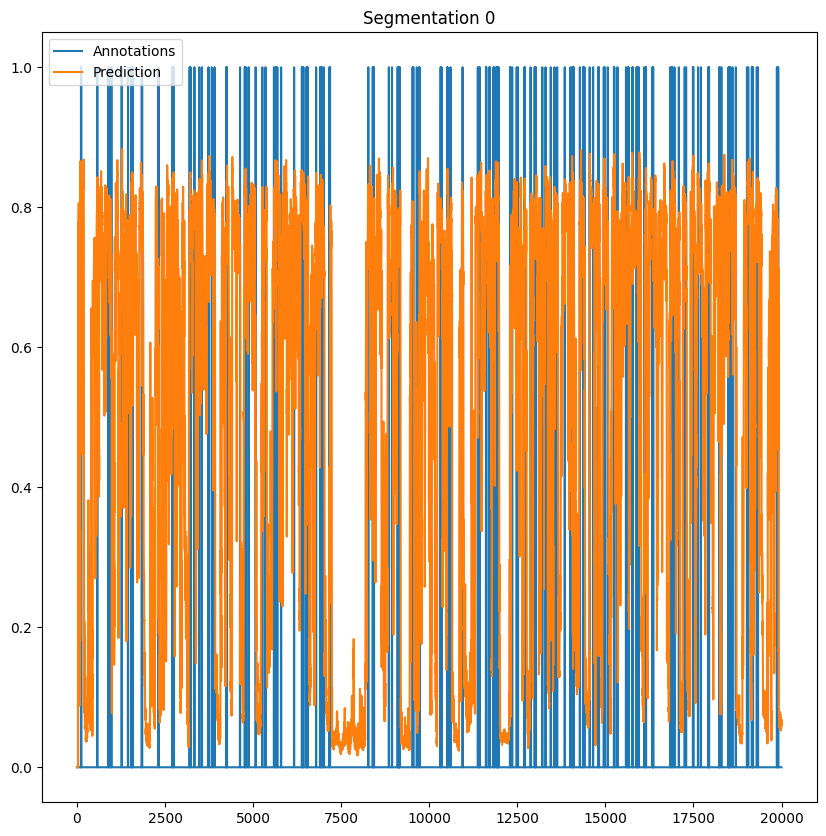

Data preprocessing: 100%|██████████| 1/1 [00:08<00:00,  8.75s/it]


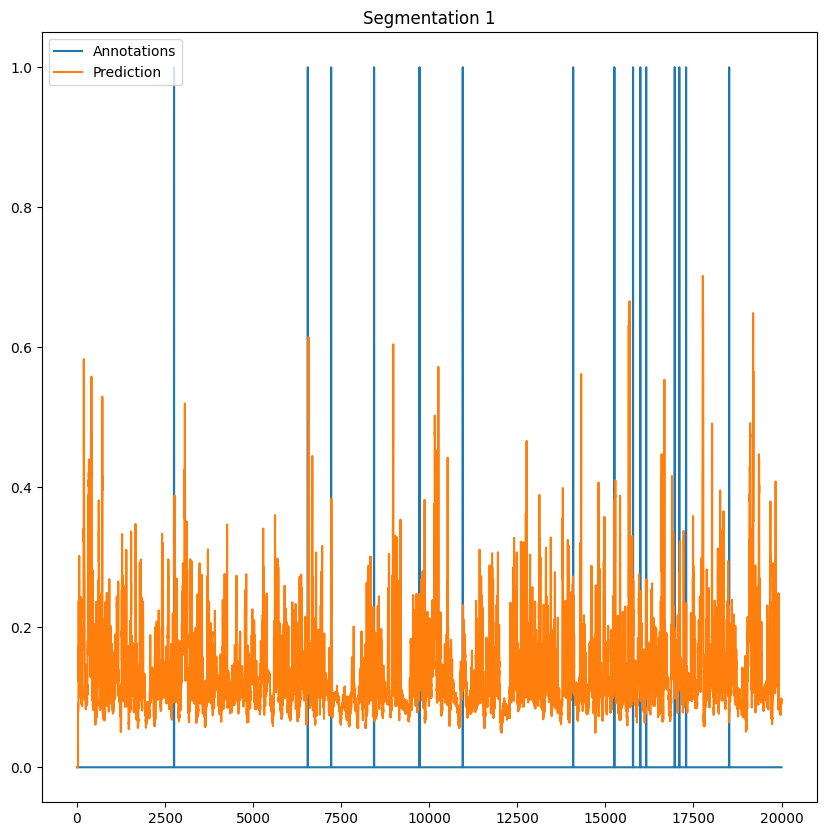

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.28s/it]


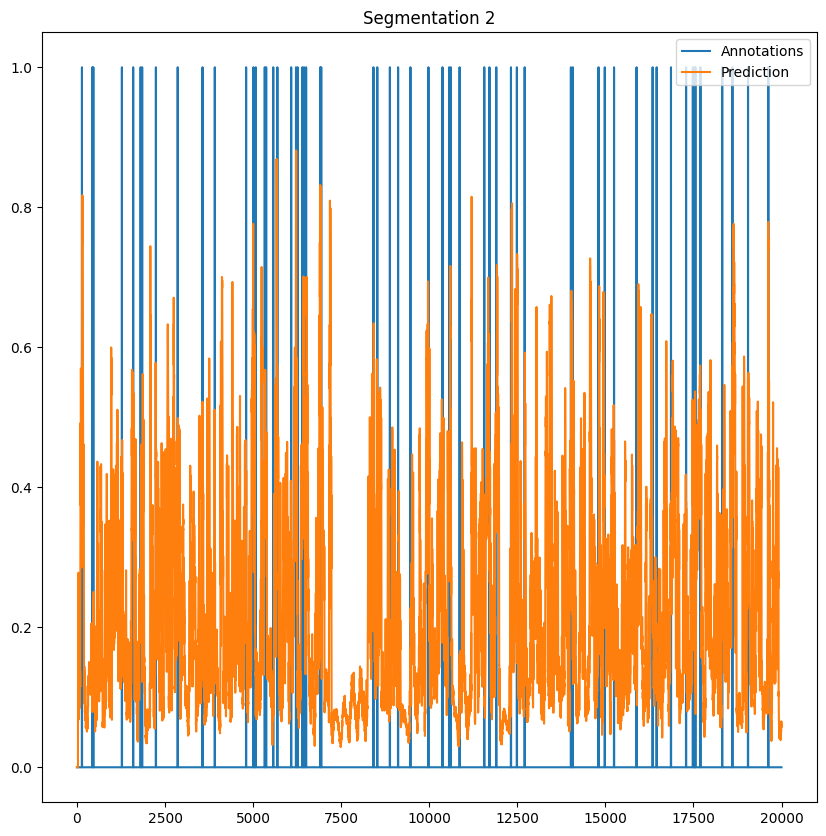

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.27s/it]


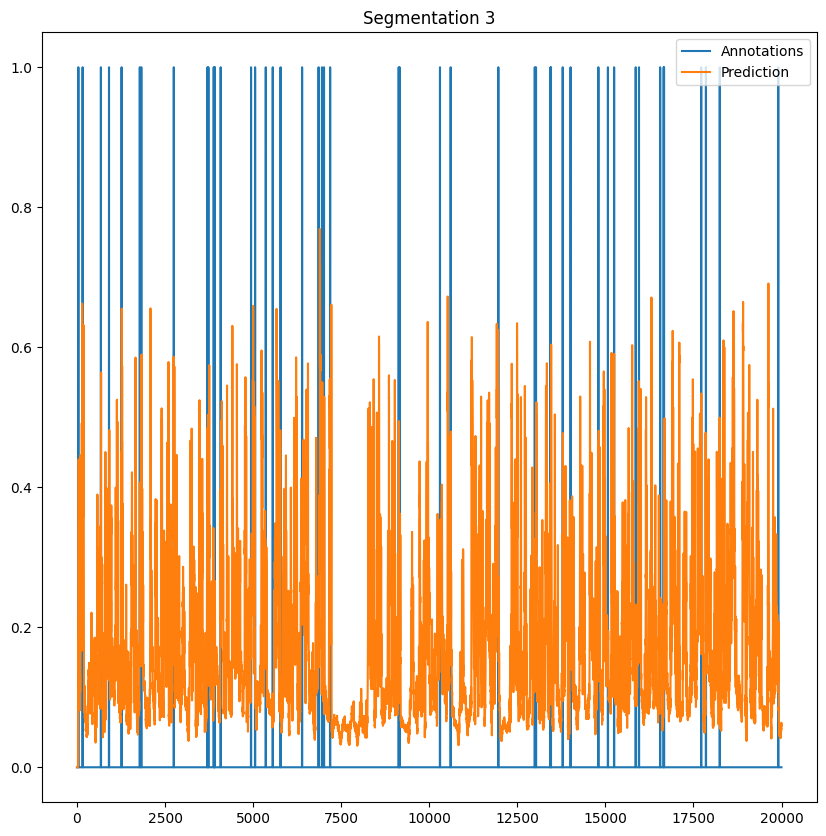

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.26s/it]


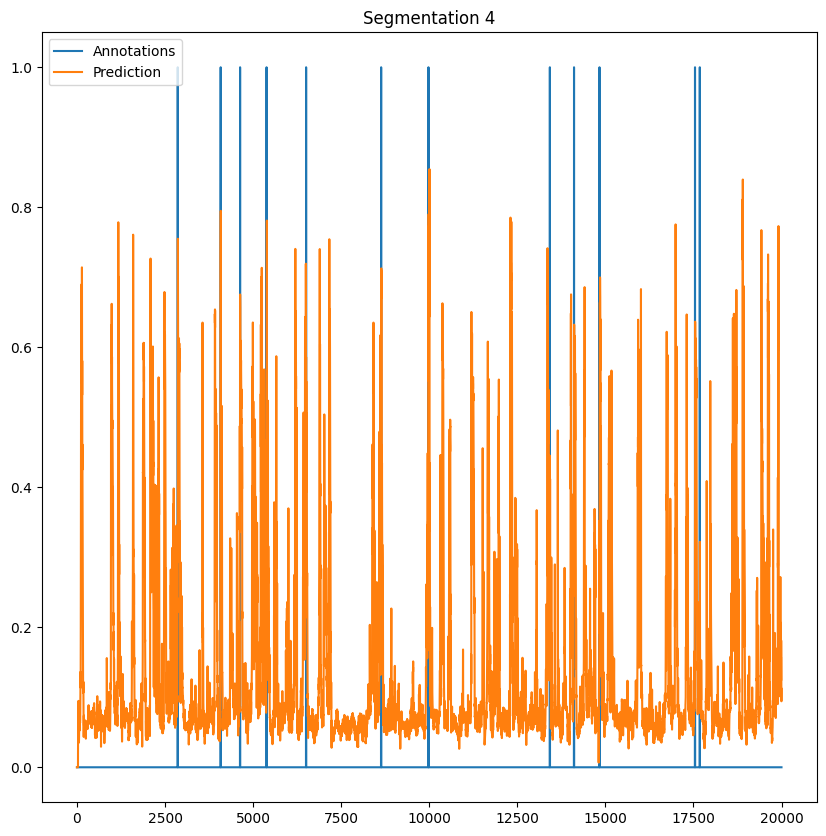

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.08s/it]


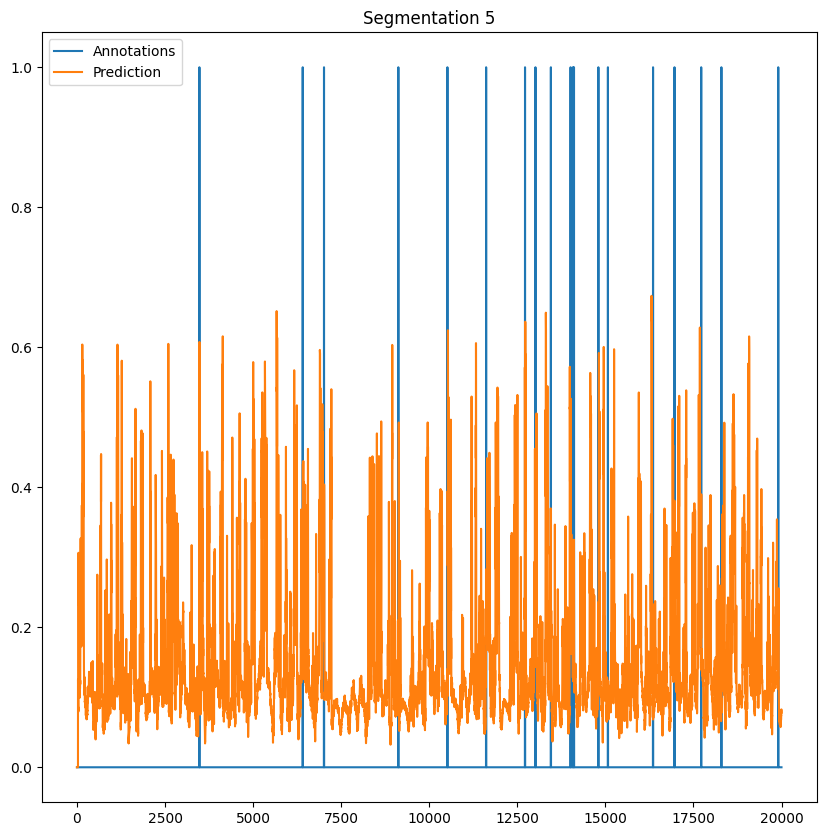

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.35s/it]


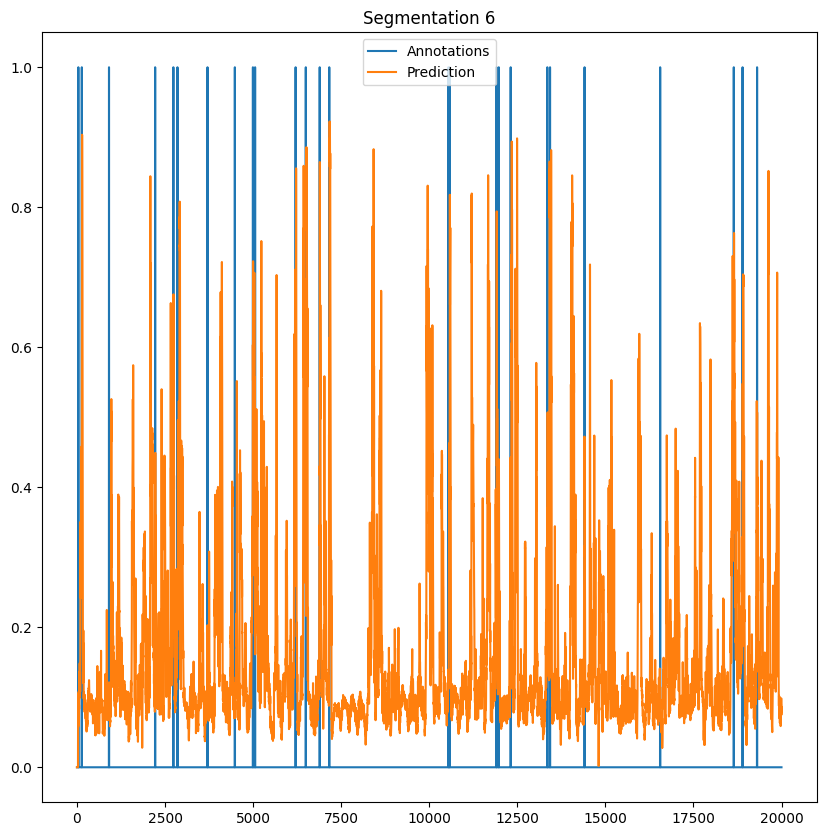

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.25s/it]


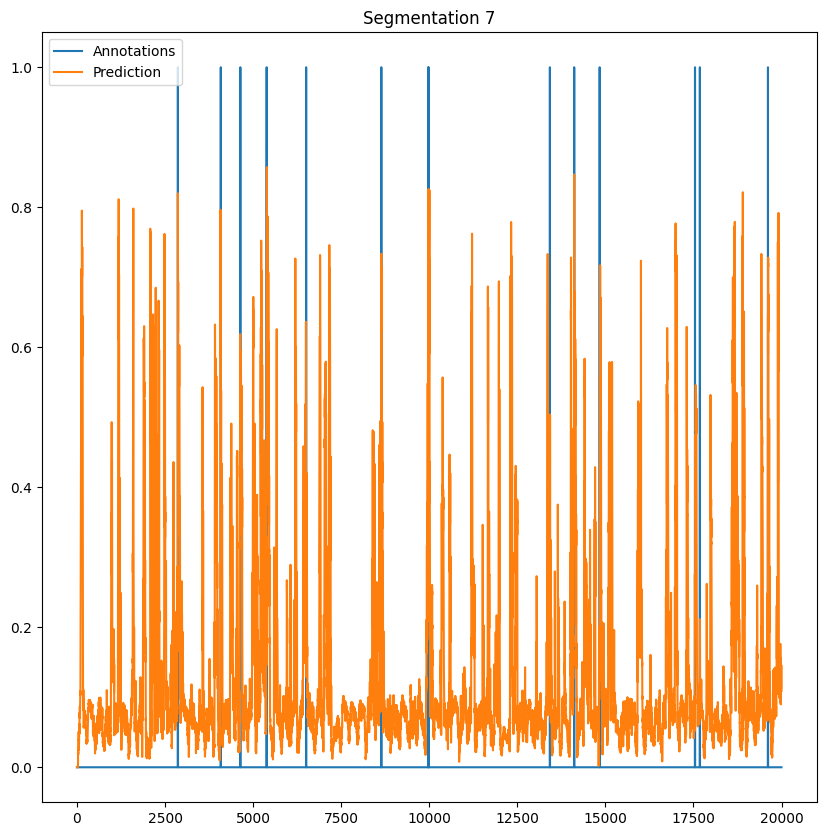

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.37s/it]


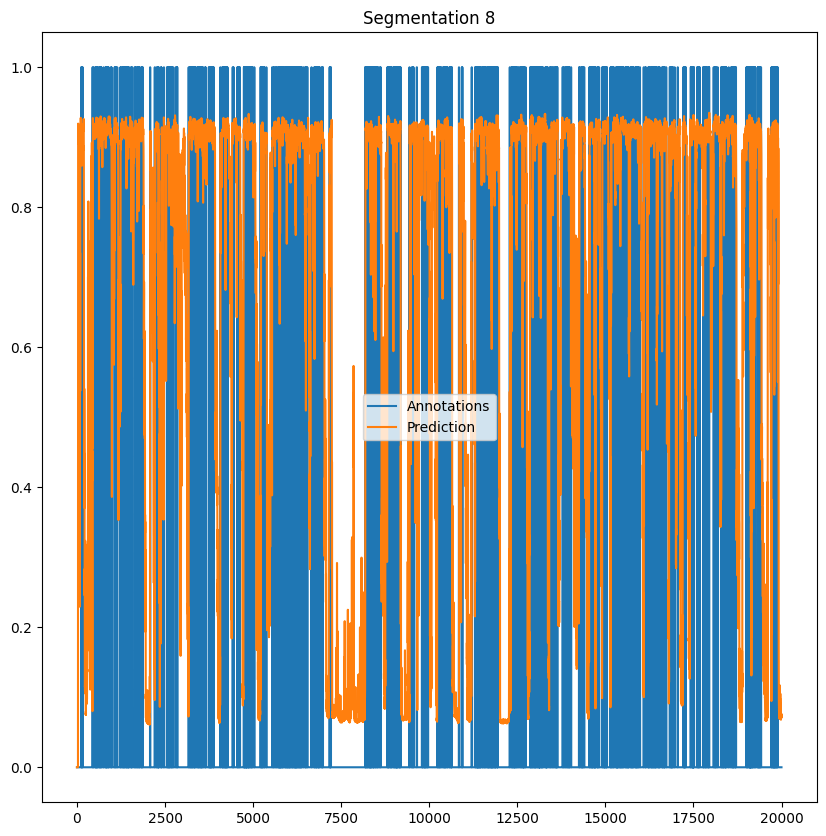

Data preprocessing: 100%|██████████| 1/1 [00:09<00:00,  9.39s/it]


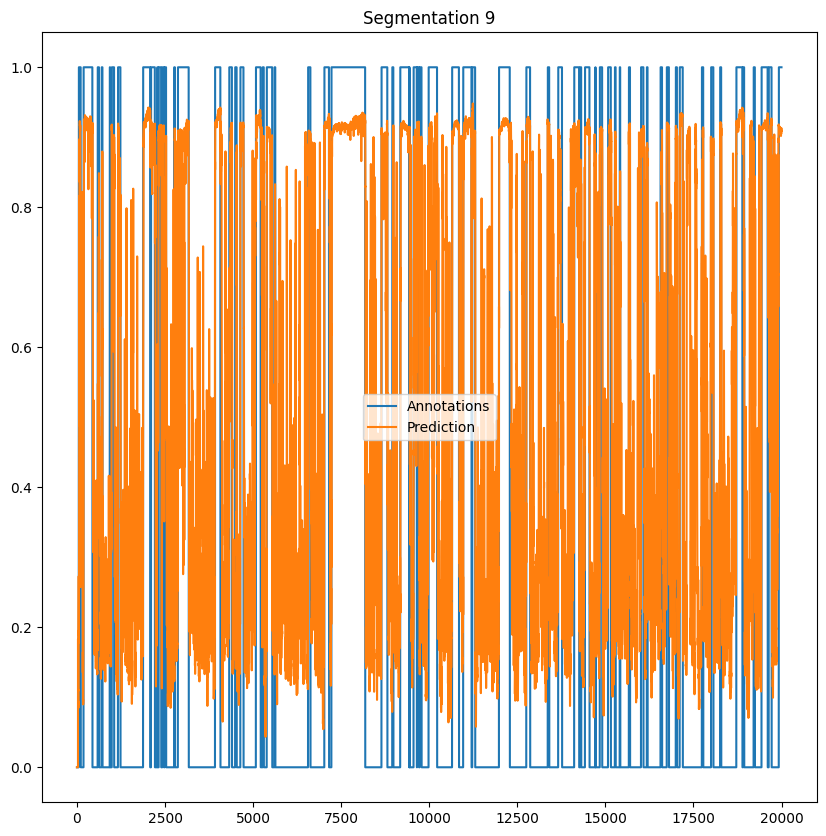

In [13]:

args = Args

precisions_combined = np.empty(0)
recalls_combined = np.empty(0)
f1_combined = np.empty(0)

prediction_x_data = []
prediction_y_data = []

annotation_x_data = []
annotation_y_data = []

for i, ann in enumerate(event_enc.keys()):

    args.focused_annotation = ann

    model_path = f"models/finetuned_{ann}.pth.tar"
    model = torch.load(model_path)
    game_analyser = GamaAnalysis(args, model)
    results, annotations = game_analyser.predict_game(game_index=0, seg_model=True, calibrate=False, ann=ann)
    fig, ax = game_analyser.plot_predictions(frame_threshold=20000, save_dir=None, annotation=ann)
    
    prediction_x_data.append(ax.get_lines()[0].get_xdata()) 
    prediction_y_data.append(ax.get_lines()[0].get_ydata())

    annotation_x_data.append(ax.get_lines()[1].get_xdata()) 
    annotation_y_data.append(ax.get_lines()[1].get_ydata())

    precision, recall, f1_score, _ = game_analyser.segmentation_evaluation(ann)

    precisions_combined = np.concatenate((precisions_combined, precision), axis=0)
    recalls_combined = np.concatenate((recalls_combined, recall), axis=0)
    f1_combined = np.concatenate((f1_combined, f1_score), axis=0)


precisions_combined = np.concatenate((np.array([np.mean(precisions_combined)]), precisions_combined), axis=0)
recalls_combined = np.concatenate((np.array([np.mean(recalls_combined)]), recalls_combined), axis=0)
f1_combined = np.concatenate((np.array([np.mean(f1_combined)]), f1_combined), axis=0)


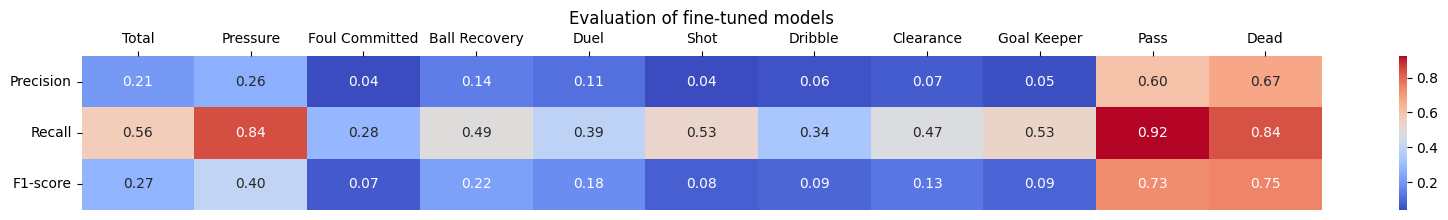

In [14]:
cols = ["Total"] + list(event_enc.keys())
rows = ["Precision", "Recall", "F1-score"]

fig = plt.figure(figsize=(20, 2))

total_scores = np.concatenate((precisions_combined, recalls_combined, f1_combined))

# ax1.set_title("Precision scores")
ax = sns.heatmap(total_scores.reshape(3,-1), annot=True, cmap="coolwarm", fmt=".2f", xticklabels=True, yticklabels=True)
ax.set_xticklabels(cols, rotation=0)
ax.xaxis.tick_top()
ax.set_yticklabels(rows, rotation=0)

plt.title("Evaluation of fine-tuned models")
plt.show()

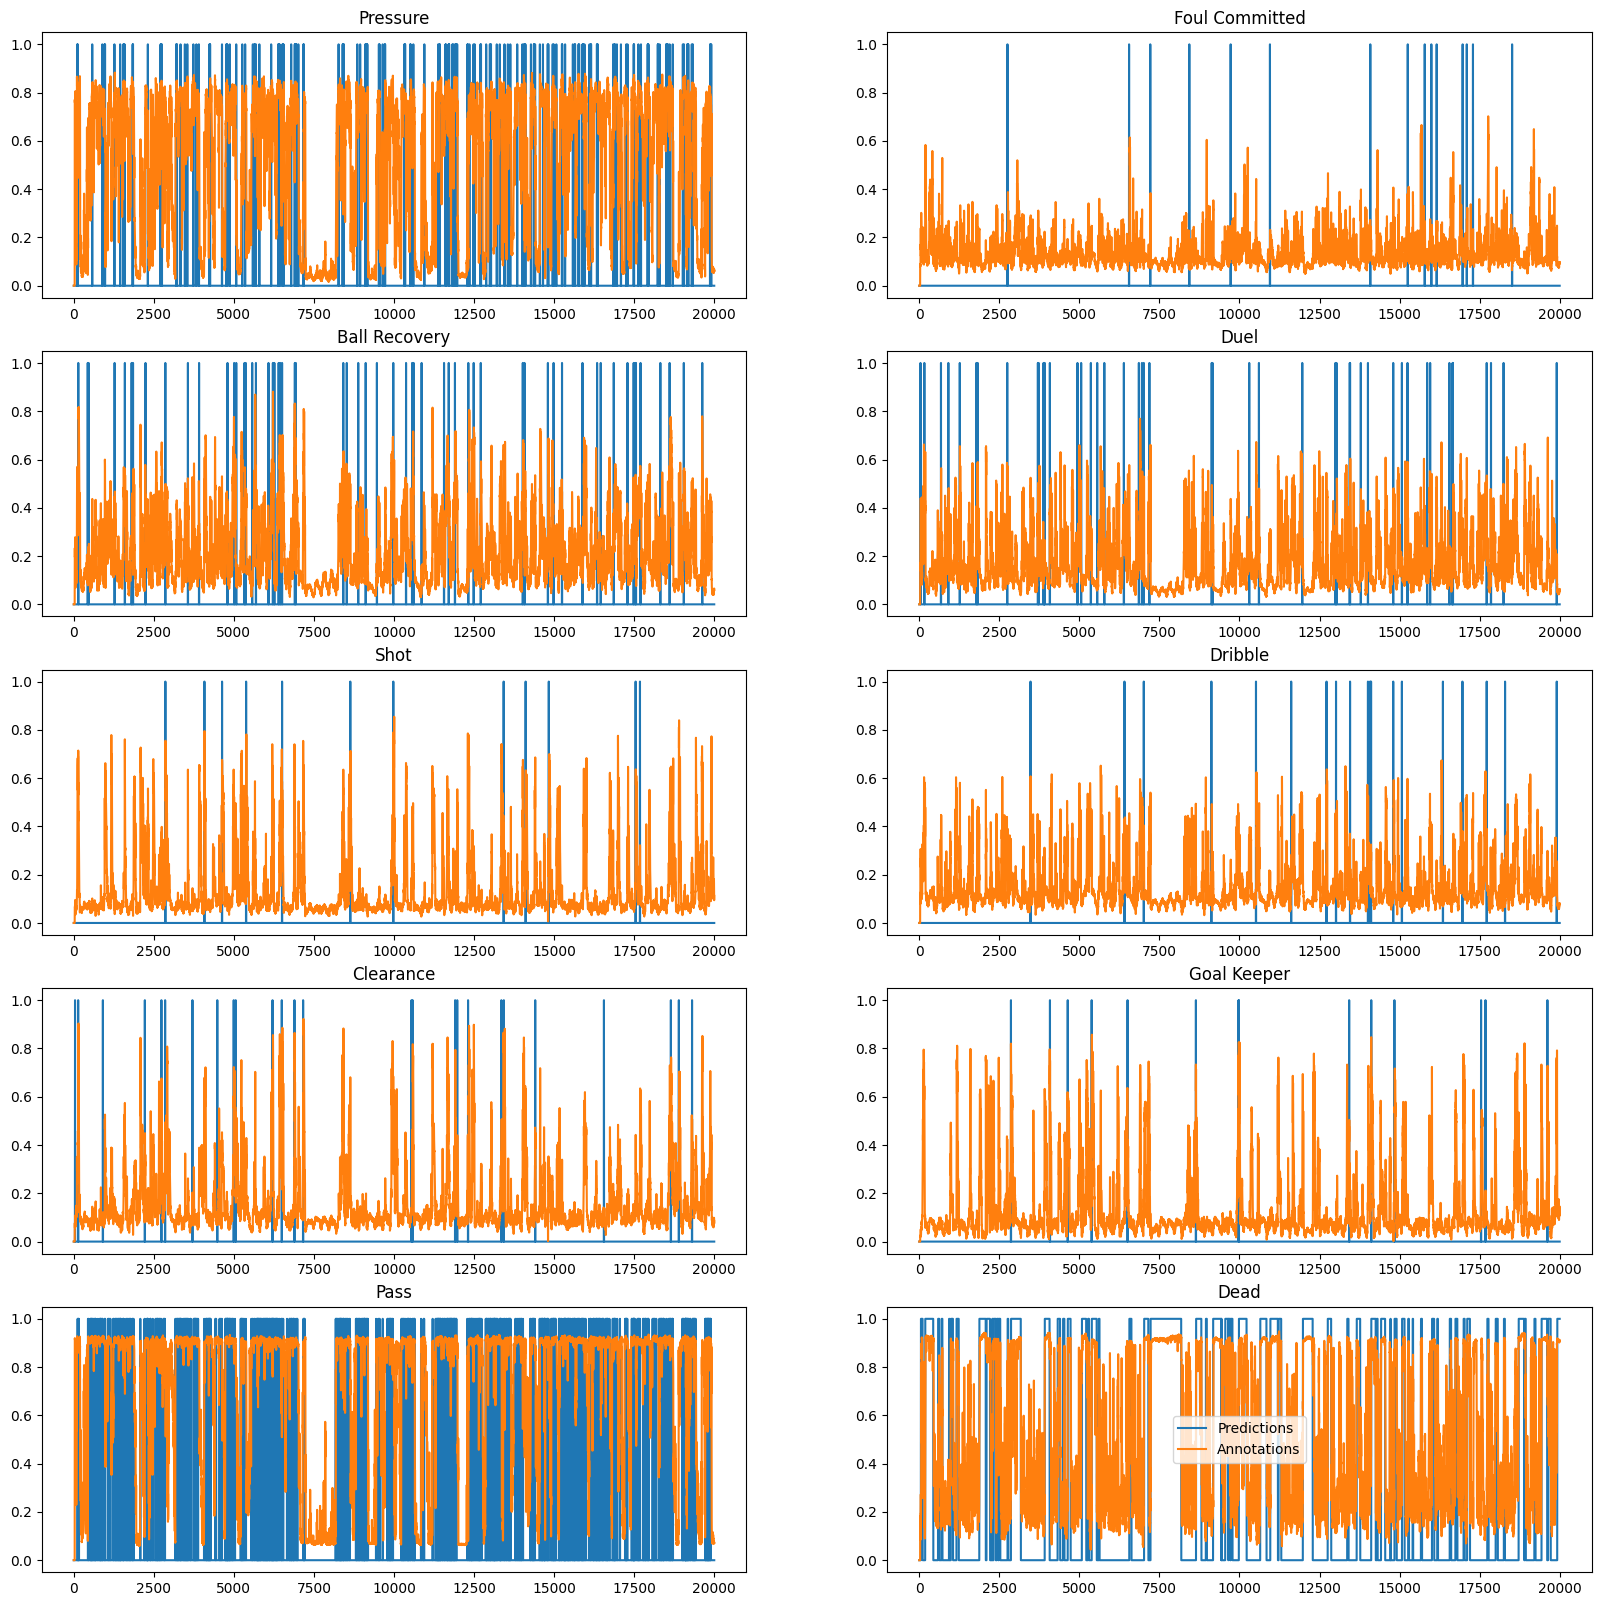

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(20, 20))
axes_flattened = axes.flatten()

for i, ax in enumerate(axes_flattened):
    ax.plot(prediction_x_data[i], prediction_y_data[i], label="Predictions")
    ax.plot(annotation_x_data[i], annotation_y_data[i], label="Annotations")
    ax.set_title(list(event_enc)[i])

plt.legend()
plt.show()
    